In [10]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw
import os

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

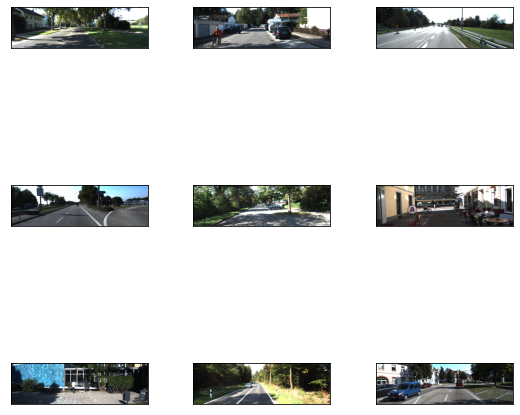

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-1.57, -2.08, -2.02, -2.25, -2.25, -1.7 , -1.55, -1.78,  2.23],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.39072   , 0.4691063 , 0.5112    , 0.5134058 ],
       [0.22586666, 0.16069244, 0.56626666, 0.3483575 ],
       [0.29925334, 0.24628824, 0.5637867 , 0.3707971 ],
       [0.37325335, 0.31165057, 0.51176   , 0.40289855],
       [0.40493333, 0.34088567, 0.55      , 0.4252657 ],
       [0.41533333, 0.52987117, 0.5918933 , 0.58776975],
       [0.44256   , 0.4702335 , 0.52602667, 0.49786633],
       [0.00266667, 0.        , 0.6708    , 0.14388889],
       [0.31493333, 0.        , 0.67413336, 0.13854267]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.36, 1.69, 3.38],
       [1.76, 1.74, 4.16],
       [1.83, 1.64, 3.71],
       [1.5 , 1.58, 3.57],
       [1.8 , 1.63, 3.79],
  

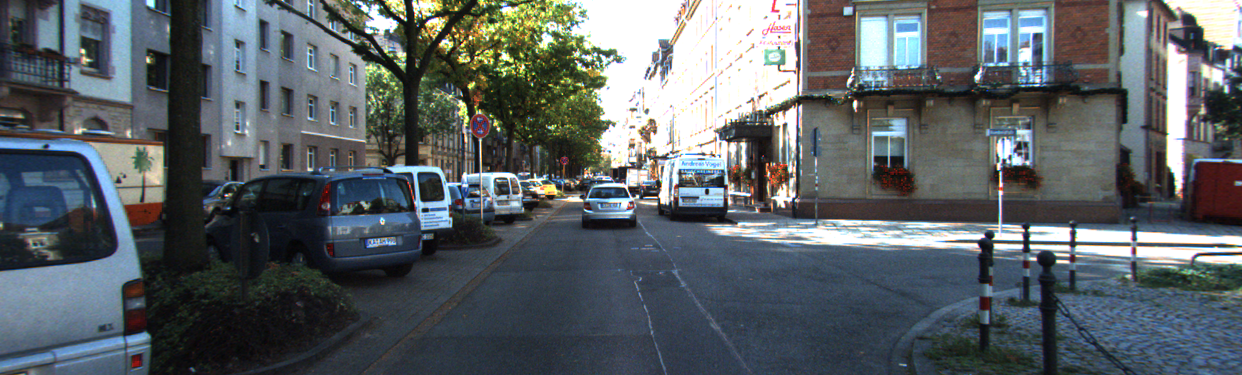

In [7]:
for example in TakeDataset:
    print('--Example--')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

1242 375
(9, 4)
[[582.63    228.48    637.65    183.3    ]
 [199.58    290.3     432.66    162.65001]
 [305.88998 262.78    460.53    163.57999]
 [387.07    235.03    500.4     183.09   ]
 [423.38    223.15    528.18    168.75   ]
 [658.1     219.25    730.01    153.04001]
 [584.03    209.04001 618.35    177.74   ]
 [  0.      374.      178.71    123.45001]
 [  0.      256.9     172.06999 122.2    ]]
[582.63 228.48 637.65 183.3 ]
[199.58    290.3     432.66    162.65001]
[305.88998 262.78    460.53    163.57999]
[387.07 235.03 500.4  183.09]
[423.38 223.15 528.18 168.75]
[658.1     219.25    730.01    153.04001]
[584.03    209.04001 618.35    177.74   ]
[  0.      374.      178.71    123.45001]
[  0.      256.9     172.06999 122.2    ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F7AF0797890>


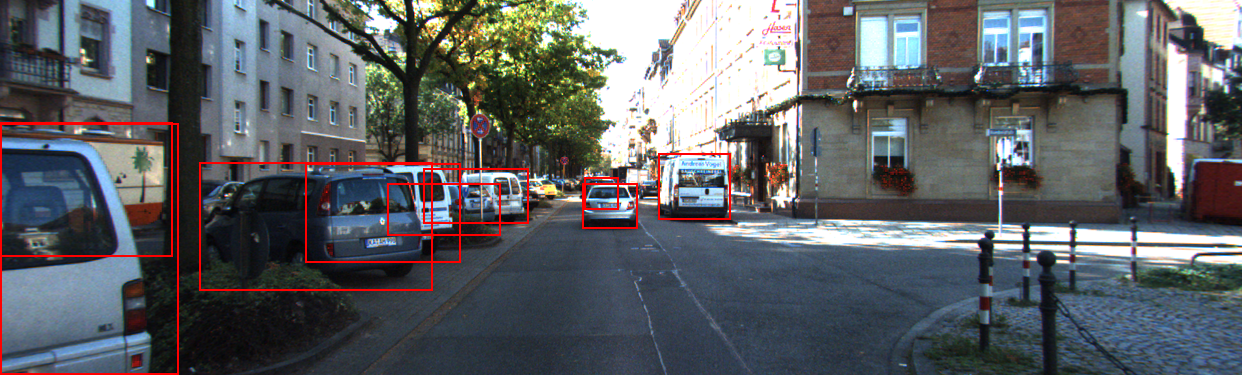

In [9]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255, 0, 0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [11]:
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

In [12]:
def parse_dataset(dataset, img_dir = 'kitti_images', total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        
    type_class_map = {
        
        0: 'car',
        1: 'car',
        2: 'car',
        3: 'person',
        4: 'person',
        5: 'person',
    }
    
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path":img_path,
                "x1":_rect[0],
                "y1":_rect[1],
                "x2":_rect[2],
                "y2":_rect[3],
                "class_name":type_class_map[_type]
            }, ignore_index=True)
            break
    return df

In [13]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [11:57<00:00,  8.85it/s]


In [14]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person" : 1,
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [15]:
save_class_format(class_txt_path)

In [18]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt 

2020-11-04 01:34:40.699699: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 01:34:41.454628: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-04 01:34:41.478466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-04 01:34:41.478894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-04 01:34:41.478913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 01:34:41.480863: I tensorflow/stream_executor/platform

Epoch 1/50
2020-11-04 01:34:49.736001: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-11-04 01:34:50.710562: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-11-04 01:34:50.739982: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-11-04 01:34:51.002128: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-04 01:35:06.410533: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/

195/195 [==============================] - ETA: 0s - loss: 1.2742 - regression_loss: 0.9886 - classification_loss: 0.2855
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
195/195 [==============================] - 56s 288ms/step - loss: 1.2742 - regression_loss: 0.9886 - classification_loss: 0.2855
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.1970 - regression_loss: 0.9327 - classification_loss: 0.2643
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 56s 287ms/step - loss: 1.1970 - regression_loss: 0.9327 - classification_loss: 0.2643
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.2366 - regression_loss: 0.9682 - classification_loss: 0.2684
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 55s 283ms/step - loss: 1.2366 - regression_loss:

 58/195 [=======>......................] - ETA: 40s - loss: 1.3037 - regression_loss: 1.0174 - classification_loss: 0.2863^C
Process Keras_worker_ForkPoolWorker-120:
Process Keras_worker_ForkPoolWorker-119:
Process Keras_worker_ForkPoolWorker-117:
Process Keras_worker_ForkPoolWorker-118:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/multiprocessing/process.py

In [19]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-11-04 02:03:16.243323: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 02:03:17.426474: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-04 02:03:17.450009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-04 02:03:17.450323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-04 02:03:17.450339: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-04 02:03:17.452363: I tensorflow/stream_executor/platform

In [ ]:
%matplotlib inlint 

%load_ext autoreload
%autoreload 2

import keras

from keras_resnettinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import time

put = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots','resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')